In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import piq
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from pathlib import Path
import torch
import os, sys
from tqdm import tqdm
import shutil
import seaborn as sns
import pickle

In [3]:
IMAGES_REF = Path('iqa/tid2013/reference_images')
IMAGES_DIS = Path('iqa/tid2013/distorted_images')
IMAGES_SAL = Path('iqa/tid2013/saliency')

In [4]:
def imread(path):
    image = cv2.imread(str(path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = torch.Tensor(image) / 255
    return image

def to_tensor(image):
    return image.permute(2, 0, 1).unsqueeze(0)

In [30]:
df = pd.read_csv('/home/alexkkir/experiments-with-saliency/iqa/tid2013_data.csv')
df['psnr'] = .0
df['psnr_sal'] = .0

In [31]:
def modify_mask(mask, alpha=0.8):
    mask = mask * alpha + (1 - alpha)
    return mask

In [32]:
device = torch.device('cuda:3')

for i in tqdm(range(len(df))):
    file_dis = df.loc[i, 'name']
    file_ref = file_dis.split('_')[0] + '.' + file_dis.split('.')[-1]
    ref = imread(IMAGES_REF / file_ref)
    dis = imread(IMAGES_DIS / file_dis)
    sal = imread(IMAGES_SAL / file_dis.replace('.bmp', '.jpeg'))

    sal = modify_mask(sal)
    
    ref = to_tensor(ref).to(device)
    dis = to_tensor(dis).to(device)
    sal = to_tensor(sal).to(device)

    before = float(piq.psnr(ref, dis))
    df.loc[i, 'psnr'] = before

    after = float(piq.psnr(ref, dis, sal))
    df.loc[i, 'psnr_sal'] = after

100%|██████████| 3000/3000 [00:26<00:00, 113.07it/s]


In [9]:
def calc_corr(df):
    out = {}
    corr = 0
    for seq in df.sequence.unique():
        corr += df[df.sequence == seq].corr().loc['subj_mean', 'psnr']
    corr /= len(df.sequence.unique())
    out['psnr'] = round(corr, 4)

    corr = 0
    for seq in df.sequence.unique():
        corr += df[df.sequence == seq].corr().loc['subj_mean', 'psnr_sal']
    corr /= len(df.sequence.unique())
    out['psnr_sal'] = round(corr, 4)
    return out

calc_corr(df)

{'psnr': 0.6645, 'psnr_sal': 0.672}

In [49]:
def make_experiment(df, alpha):
    for i in (range(len(df))):
        file_dis = df.loc[i, 'name']
        file_ref = file_dis.split('_')[0] + '.' + file_dis.split('.')[-1]
        ref = imread(IMAGES_REF / file_ref)
        dis = imread(IMAGES_DIS / file_dis)
        sal = imread(IMAGES_SAL / file_dis.replace('.bmp', '.jpeg'))

        sal = modify_mask(sal, alpha)
        
        ref = to_tensor(ref).to(device)
        dis = to_tensor(dis).to(device)
        sal = to_tensor(sal).to(device)

        # before = float(piq.psnr(ref, dis))
        # df.loc[i, 'psnr'] = before

        after = float(piq.psnr(ref, dis, sal))
        df.loc[i, 'psnr_sal'] = after

    out = calc_corr(df)['psnr_sal']
    return out

In [56]:
alpha_space = np.linspace(0.7, 0.9, 10)
out = {}
for alpha in tqdm(alpha_space):
    result = make_experiment(df, alpha)
    out[alpha] = result

100%|██████████| 10/10 [03:36<00:00, 21.67s/it]


Text(0.5, 1.0, 'Как подобрать коэффициент $\\alpha$ в формуле\n $mask = mask \\cdot \\alpha + (1 - \\alpha)$')

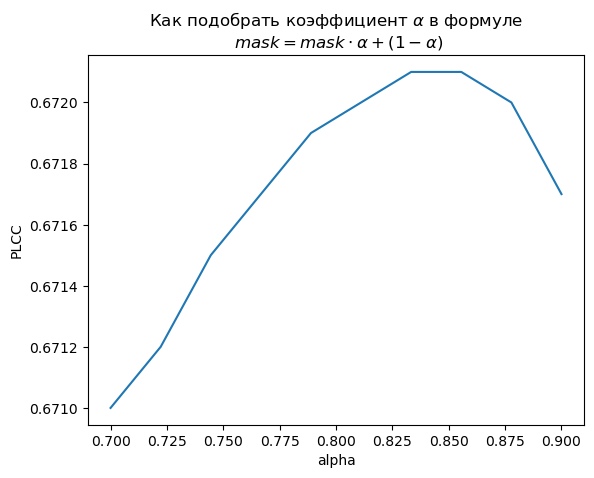

In [64]:
plt.plot(out.keys(), out.values())
plt.xlabel('alpha')
plt.ylabel('PLCC')
plt.title('Как подобрать коэффициент $\\alpha$ в формуле\n $mask = mask \cdot \\alpha + (1 - \\alpha)$')

In [67]:
with open('psnr.pkl', 'rb') as f:
    exp = pickle.load(f)

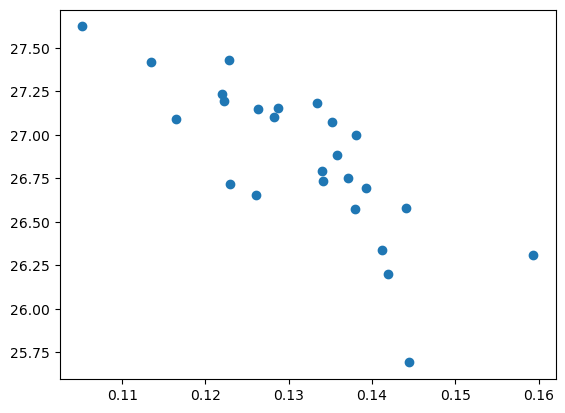

In [77]:
plt.scatter(exp['grouped'].subj_std, exp['grouped'].psnr)

In [84]:
df = exp['grouped']
df['corr_psnr'] = .0
df['corr_psnr_sal'] = .0
df

,subj_mean,psnr,psnr_sal,subj_std,plcc,corr_psnr,corr_psnr_sal
sequence,,,,,,,
i01,4.470368,26.732093,26.577744,0.134118,0.702321,0.0,0.0
i02,4.472146,27.235060,26.834593,0.121983,0.720347,0.0,0.0
i03,4.480565,27.419527,26.877854,0.113507,0.630745,0.0,0.0
i04,4.488106,27.623177,27.381511,0.105197,0.623313,0.0,0.0
i05,4.471393,26.336418,26.141792,0.141207,0.710180,0.0,0.0
i06,4.476146,26.582243,26.250188,0.144028,0.687859,0.0,0.0
i07,4.477217,27.194746,26.597758,0.122225,0.699438,0.0,0.0
i08,4.473357,26.312300,26.255200,0.159319,0.681659,0.0,0.0
i09,4.469769,27.073333,26.567888,0.135184,0.648745,0.0,0.0


In [88]:
result = exp['results']

In [90]:
for seq in df.index:
    df.loc[seq, 'corr_psnr'] = result[result.sequence == seq].corr().loc['subj_mean', 'psnr']
    df.loc[seq, 'corr_psnr_sal'] = result[result.sequence == seq].corr().loc['subj_mean', 'psnr_sal']
df.head()

,subj_mean,psnr,psnr_sal,subj_std,plcc,corr_psnr,corr_psnr_sal
sequence,,,,,,,
i01,4.470368,26.732093,26.577744,0.134118,0.702321,0.675681,0.702321
i02,4.472146,27.235060,26.834593,0.121983,0.720347,0.695226,0.720347
i03,4.480565,27.419527,26.877854,0.113507,0.630745,0.627925,0.630745
i04,4.488106,27.623177,27.381511,0.105197,0.623313,0.610611,0.623313
i05,4.471393,26.336418,26.141792,0.141207,0.710180,0.710334,0.710180


In [100]:
df[['corr_psnr', 'corr_psnr_sal']].mean()

corr_psnr        0.664457
corr_psnr_sal    0.671966
dtype: float64

Text(0.5, 1.0, 'Чем больще разброс оценок, тем хуже psnr')

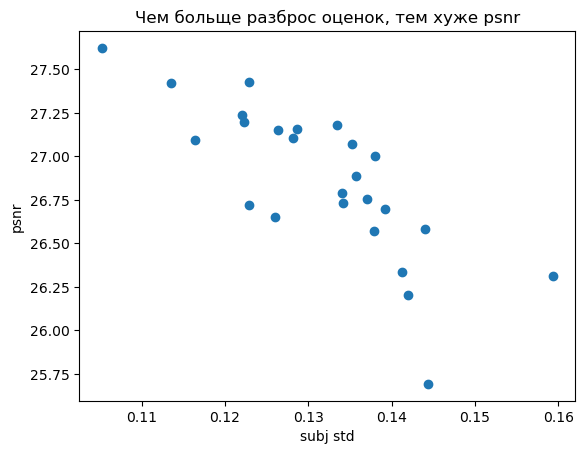

In [102]:
plt.scatter(df.subj_std, df.psnr)
plt.xlabel('subj std')
plt.ylabel('psnr')
plt.title('Чем больще разброс оценок, тем хуже psnr')